In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('MountainCar-v0').env
env.reset()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_size, 50)
        self.linear2 = nn.Linear(50, 50)
        self.head = nn.Linear(50, output_size)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.head(x)

In [5]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 3
LR = 0.001

In [6]:
steps_done = 0

def eps_greedy_select_action(policy_net, state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)
    
def select_action(policy_net, state):
    with torch.no_grad():
        return policy_net(state).max(1)[1].view(1, 1)

In [7]:
def optimize_model(optimizer, policy_net, target_net, memory, perturb=False):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    rewards = list(batch.reward)
    if perturb:
        for i, _ in enumerate(rewards):
            rewards[i] += np.random.normal(0, 1)

    reward_batch = torch.cat(tuple(rewards))

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss_fn = nn.MSELoss()
    loss = loss_fn(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
#     for param in policy_net.parameters():
#         param.grad.data.clamp_(-1, 1)
    optimizer.step()

Episode 99
Cumulative reward: -500.0
Episode 199
Cumulative reward: -500.0
Episode 299
Cumulative reward: -500.0
Episode 399
Cumulative reward: -500.0
Episode 499
Cumulative reward: -500.0
Episode 599
Cumulative reward: -500.0
Episode 699
Cumulative reward: -500.0
Episode 799
Cumulative reward: -500.0
Episode 899
Cumulative reward: -500.0
Episode 999
Cumulative reward: -500.0
Episode 1099
Cumulative reward: -500.0
Episode 1199
Cumulative reward: -500.0
Episode 1299
Cumulative reward: -500.0
Episode 1399
Cumulative reward: -500.0
Episode 1499
Cumulative reward: -500.0
Episode 1599
Cumulative reward: -500.0
Episode 1699
Cumulative reward: -500.0
Episode 1799
Cumulative reward: -500.0
Episode 1899
Cumulative reward: -500.0
Episode 1999
Cumulative reward: -500.0
Complete


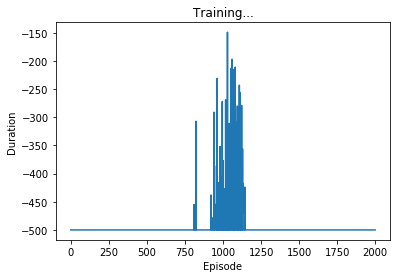

In [14]:
policy_net = DQN(INPUT_SIZE, OUTPUT_SIZE).to(device)
target_net = DQN(INPUT_SIZE, OUTPUT_SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.SGD(policy_net.parameters(), lr=LR)
num_episodes = 2000
cumulative_rewards_2 = [0 for _ in range(num_episodes)]
eps_greedy_memory = ReplayMemory(100000)

episode_steps = []
for i_episode in tqdm(range(num_episodes), ascii=True):
    state = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float)
    for t in range(500):
#         if (i_episode + 1) % 100 == 0:
#             env.render()
        action = eps_greedy_select_action(policy_net, state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor([next_state], device=device, dtype=torch.float)
        reward = torch.tensor([reward], device=device)
        if done:
            next_state = None
        
        eps_greedy_memory.push(state, action, next_state, reward)
        cumulative_rewards_2[i_episode] += reward.item()
        
        if done:
            break
        
        state = next_state
        optimize_model(optimizer, policy_net, target_net, eps_greedy_memory)

    if (i_episode + 1) % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if (i_episode + 1) % 100 == 0:
        print('Episode ' + str(i_episode))
        print('Cumulative reward: ' + str(cumulative_rewards_2[i_episode]))
        
print('Complete')
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.plot(cumulative_rewards_2)
plt.show()
env.close()